In [ ]:
This project aims to see if curve detectors in neural networks as identified by
classic mechanistic interpretability methods are also responsible for generating
and perciving curved in illusions such as the Neon Color spreading illusion.

First, we need to identify the curve detectors in the resnet50 or InceptionV3.
Then, we ablate these curve detectors and see if Generative Inference (GInf) can no longer 
generate the curve in the illusion.

In [14]:
!pip install lucid_torch

ERROR: Could not find a version that satisfies the requirement lucid_torch (from versions: none)
ERROR: No matching distribution found for lucid_torch


In [9]:
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import resnet50

# Load pre-trained ResNet50 from torchvision through lucent’s modelzoo
model = resnet50(pretrained=True)
model.eval()

from lucent.modelzoo.util import get_model_layers
print(get_model_layers(model))

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer1_0', 'layer1_0_conv1', 'layer1_0_bn1', 'layer1_0_conv2', 'layer1_0_bn2', 'layer1_0_conv3', 'layer1_0_bn3', 'layer1_0_relu', 'layer1_0_downsample', 'layer1_0_downsample_0', 'layer1_0_downsample_1', 'layer1_1', 'layer1_1_conv1', 'layer1_1_bn1', 'layer1_1_conv2', 'layer1_1_bn2', 'layer1_1_conv3', 'layer1_1_bn3', 'layer1_1_relu', 'layer1_2', 'layer1_2_conv1', 'layer1_2_bn1', 'layer1_2_conv2', 'layer1_2_bn2', 'layer1_2_conv3', 'layer1_2_bn3', 'layer1_2_relu', 'layer2', 'layer2_0', 'layer2_0_conv1', 'layer2_0_bn1', 'layer2_0_conv2', 'layer2_0_bn2', 'layer2_0_conv3', 'layer2_0_bn3', 'layer2_0_relu', 'layer2_0_downsample', 'layer2_0_downsample_0', 'layer2_0_downsample_1', 'layer2_1', 'layer2_1_conv1', 'layer2_1_bn1', 'layer2_1_conv2', 'layer2_1_bn2', 'layer2_1_conv3', 'layer2_1_bn3', 'layer2_1_relu', 'layer2_2', 'layer2_2_conv1', 'layer2_2_bn1', 'layer2_2_conv2', 'layer2_2_bn2', 'layer2_2_conv3', 'layer2_2_bn3', 'layer2_2_relu', 'layer2_3', 

100%|██████████| 512/512 [00:04<00:00, 124.56it/s]


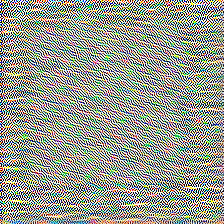

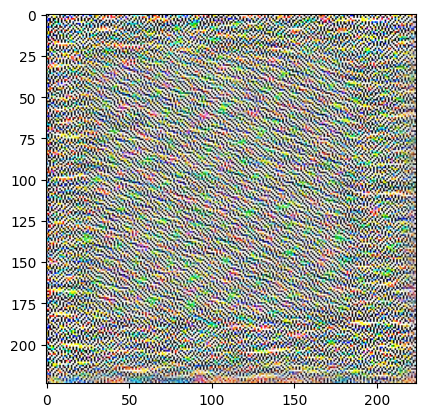

In [10]:
import torch
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import resnet50
import matplotlib.pyplot as plt

# Choose device and move the model to it, then set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True).to(device).eval()

# Choose a valid layer; for instance, "layer1_0_conv2"
layer_name = "layer1_0_conv2"
channel = 10

# Define the objective for the chosen channel
objective = objectives.channel(layer_name, channel)

# Create a callable parameter function (ensure input image is on the correct device)
param_f = lambda: param.image(224, 224, device=device)

# Define some transforms for regularization
transforms = [
    transform.jitter(16),
    transform.pad(32)
]

# Run the visualization
vis = render.render_vis(model, objective, param_f=param_f, transforms=transforms, thresholds=[512])

# Extract the actual image from the nested lists
result_img = vis[0][0]  # first threshold, first iteration

# If result_img is shape (3, 224, 224), do:
#   result_img = result_img.transpose(1,2,0)  # or permute if it’s a torch tensor
# If it’s shape (1, 224, 224), do:
#   result_img = np.squeeze(result_img, axis=0)  # and maybe `cmap='gray'`

plt.imshow(result_img)  # or plt.imshow(result_img, cmap='gray')
plt.show()

Maximizing activation of channel 0 in layer1_0_conv2...


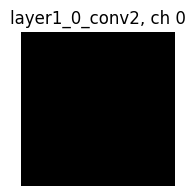

Maximizing activation of channel 1 in layer1_0_conv2...


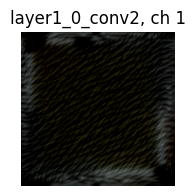

Maximizing activation of channel 2 in layer1_0_conv2...


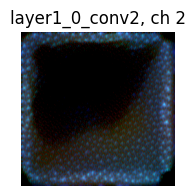

Maximizing activation of channel 3 in layer1_0_conv2...


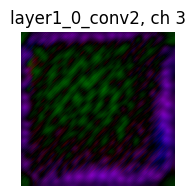

Maximizing activation of channel 4 in layer1_0_conv2...


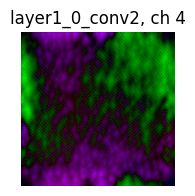

Maximizing activation of channel 5 in layer1_0_conv2...


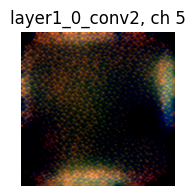

Maximizing activation of channel 6 in layer1_0_conv2...


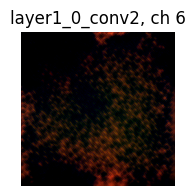

Maximizing activation of channel 7 in layer1_0_conv2...


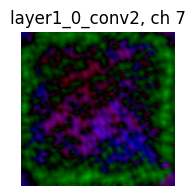

In [20]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

from lucent.optvis import render, transform, objectives
from lucent.modelzoo import resnet50

###############################################################################
# 1) EXACT FFT IMAGE PARAM IMPLEMENTATION (matching lucent dev's `fft_image`)
###############################################################################
def rfft2d_freqs(h, w):
    """Compute 2D spectrum frequencies for a real‐valued input signal of size (h, w)."""
    fy = np.fft.fftfreq(h)  # shape (h,)
    fx = np.fft.fftfreq(w)  # shape (w,)
    return np.sqrt(fx[None, :]**2 + fy[:, None]**2)  # shape (h, w)

def fft_image(shape=(1, 3, 224, 224), device="cuda", sd=0.01, decay_power=1.0):
    """
    Creates a learnable real+imag frequency spectrum param, plus a function
    that performs inverse FFT to produce a [B, C, H, W] image in pixel space.

    shape: (batch, channels, height, width)
    device: which device to store the parameter on
    sd: standard deviation for random init
    decay_power: frequency decay exponent
    """
    B, C, H, W = shape
    freqs = rfft2d_freqs(H, W)           # shape (H, W)
    init_val_size = (B, C) + freqs.shape + (2,)  # +2 for real+imag
    spectrum_real_imag = (torch.randn(*init_val_size) * sd).to(device).requires_grad_(True)

    # Precompute frequency decay scaling
    freq_scale = 1.0 / np.maximum(freqs, 1.0/max(H, W))**decay_power
    freq_scale_t = torch.tensor(freq_scale, dtype=torch.float32, device=device)[None, None, :, :, None]
    # shape => (B=1, C=1, H, W, 1)

    def to_spatial_image():
        """
        Convert the scaled spectrum (real+imag) -> real-space image via irfft2.
        Returns a [B, C, H, W] tensor in pixel space.
        """
        scaled_spectrum = spectrum_real_imag * freq_scale_t
        real_part = scaled_spectrum[..., 0]
        imag_part = scaled_spectrum[..., 1]
        cplx = torch.complex(real_part, imag_part)  # shape (B,C,H,W)
        img_spatial = torch.fft.irfft2(cplx, s=(H, W))
        return img_spatial  # [B, C, H, W]

    # Lucent expects (params, image_f), so it can optimize `params` each iteration
    return [spectrum_real_imag], to_spatial_image

###############################################################################
# 2) Activation Maximization with Fourier Param
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True).to(device).eval()

def param_f():
    # Returns the (params, image_func) for a single image [1,3,224,224]
    return fft_image(shape=(1, 3, 224, 224), device=device, sd=0.01, decay_power=1.0)

def run_activation_max_fft(layer_name, channel_idx, n_iter=256):
    """
    Maximize activation for (layer_name, channel_idx) using a Fourier-based param.
    """
    # Objective to maximize channel `channel_idx` in `layer_name`
    objective_f = objectives.channel(layer_name, channel_idx)

    # A few transforms for better interpretability
    transforms_ = [
        transform.jitter(8),
        transform.pad(16),
        transform.random_scale([1.0, 1.2]),
        transform.random_rotate([-15, 15]),
    ]
    
    # thresholds=[n_iter] => single phase of optimization for n_iter steps
    vis = render.render_vis(
        model,
        objective_f,
        param_f=param_f,
        transforms=transforms_,
        thresholds=[n_iter],
        show_image=False,
        progress=False
    )
    # Lucent returns nested lists: vis[phase_idx][image_idx]
    # We'll grab the final image from phase 0, index 0
    result_img = vis[0][0]

    # If it's a PyTorch tensor with shape [B,C,H,W], convert for plt.imshow
    if isinstance(result_img, torch.Tensor):
        if len(result_img.shape) == 4:
            # shape (B,C,H,W), typically B=1
            result_img = result_img[0]  # shape (C,H,W)
        # shape (C,H,W) -> (H,W,C)
        result_img = result_img.detach().cpu().permute(1,2,0).numpy()
    else:
        # If it's already a NumPy array with shape (C,H,W)
        if len(result_img.shape) == 3 and result_img.shape[0] in [1,3]:
            result_img = np.transpose(result_img, (1,2,0))

    return result_img

###############################################################################
# 3) Example usage scanning a few channels
###############################################################################
if __name__ == "__main__":
    # Let's pick an early layer. For example: "layer1_0_conv2"
    layer_name = "layer1_0_conv2"

    for ch in range(0, 8):
        print(f"Maximizing activation of channel {ch} in {layer_name}...")
        img = run_activation_max_fft(layer_name, ch, n_iter=256)

        plt.figure(figsize=(2,2))
        plt.title(f"{layer_name}, ch {ch}")
        plt.axis("off")
        plt.imshow(img)
        plt.show()

Maximizing channel 0 in layer2_0_conv2...
Maximizing channel 1 in layer2_0_conv2...
Maximizing channel 2 in layer2_0_conv2...
Maximizing channel 3 in layer2_0_conv2...
Maximizing channel 4 in layer2_0_conv2...
Maximizing channel 5 in layer2_0_conv2...
Maximizing channel 6 in layer2_0_conv2...
Maximizing channel 7 in layer2_0_conv2...
Maximizing channel 8 in layer2_0_conv2...
Maximizing channel 9 in layer2_0_conv2...
Maximizing channel 10 in layer2_0_conv2...
Maximizing channel 11 in layer2_0_conv2...
Maximizing channel 12 in layer2_0_conv2...
Maximizing channel 13 in layer2_0_conv2...
Maximizing channel 14 in layer2_0_conv2...
Maximizing channel 15 in layer2_0_conv2...
Maximizing channel 16 in layer2_0_conv2...
Maximizing channel 17 in layer2_0_conv2...
Maximizing channel 18 in layer2_0_conv2...
Maximizing channel 19 in layer2_0_conv2...
Maximizing channel 20 in layer2_0_conv2...
Maximizing channel 21 in layer2_0_conv2...
Maximizing channel 22 in layer2_0_conv2...
Maximizing channel 23

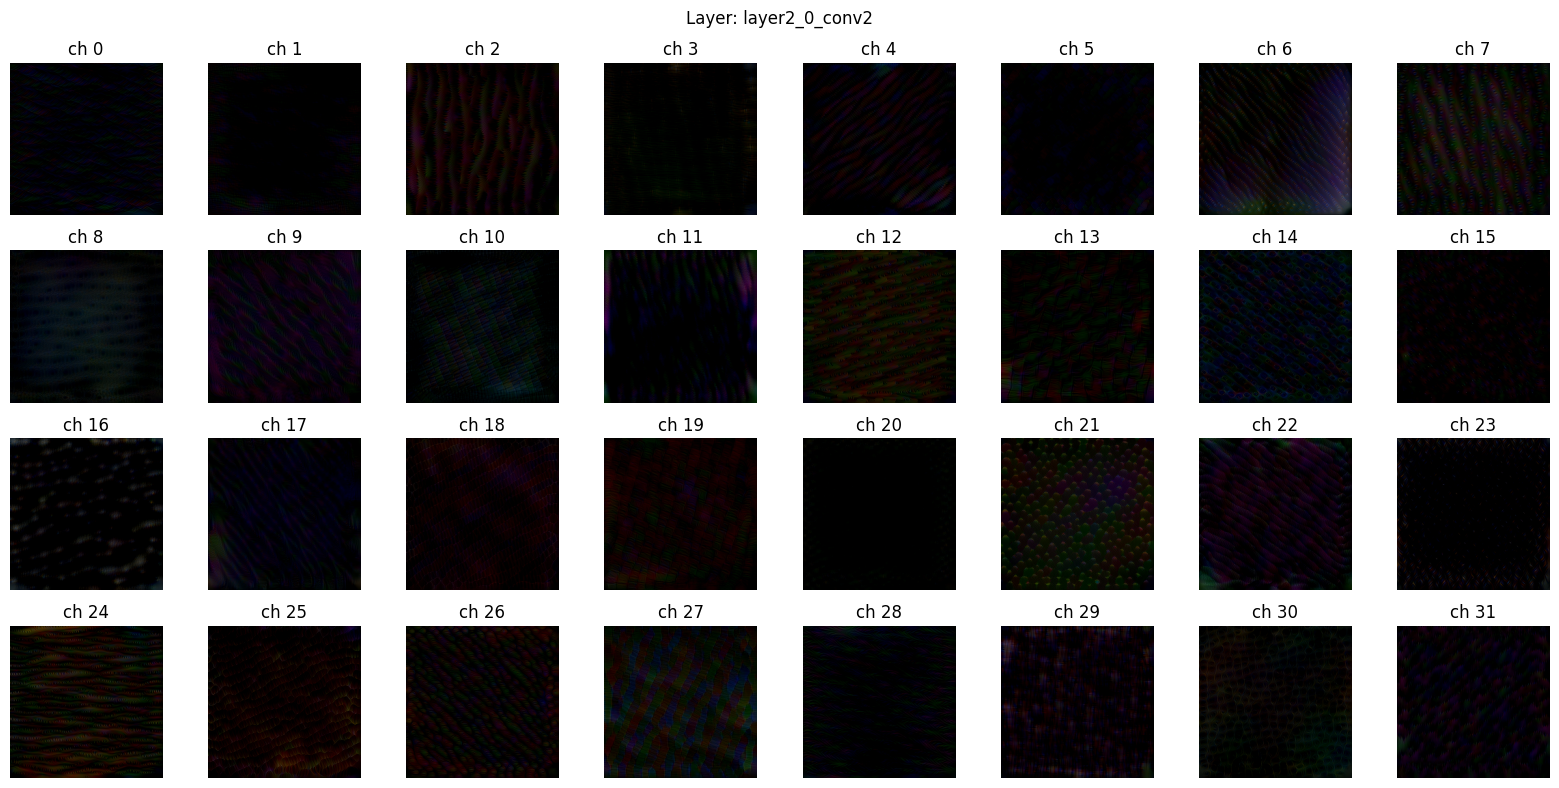

In [24]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

from lucent.optvis import render, transform, objectives
from lucent.modelzoo import resnet50

###############################################################################
# 1) EXACT FFT IMAGE PARAM IMPLEMENTATION
###############################################################################
def rfft2d_freqs(h, w):
    """Compute 2D spectrum frequencies for a real‐valued input signal of size (h, w)."""
    fy = np.fft.fftfreq(h)  # shape (h,)
    fx = np.fft.fftfreq(w)  # shape (w,)
    return np.sqrt(fx[None, :]**2 + fy[:, None]**2)  # shape (h, w)

def fft_image(shape=(1, 3, 224, 224), device="cuda", sd=0.01, decay_power=1.0):
    """
    Creates a learnable real+imag frequency spectrum param, plus a function
    that performs inverse FFT to produce a [B, C, H, W] image in pixel space.
    """
    B, C, H, W = shape
    freqs = rfft2d_freqs(H, W)           
    init_val_size = (B, C) + freqs.shape + (2,)  # +2 for real+imag
    spectrum_real_imag = (torch.randn(*init_val_size) * sd).to(device).requires_grad_(True)

    # Precompute frequency decay scaling
    freq_scale = 1.0 / np.maximum(freqs, 1.0/max(H, W))**decay_power
    freq_scale_t = torch.tensor(freq_scale, dtype=torch.float32, device=device)[None, None, :, :, None]

    def to_spatial_image():
        """Convert scaled spectrum -> real-space image via irfft2."""
        scaled_spectrum = spectrum_real_imag * freq_scale_t
        real_part = scaled_spectrum[..., 0]
        imag_part = scaled_spectrum[..., 1]
        cplx = torch.complex(real_part, imag_part)
        img_spatial = torch.fft.irfft2(cplx, s=(H, W))  # shape [B,C,H,W]
        return img_spatial

    return [spectrum_real_imag], to_spatial_image

###############################################################################
# 2) Activation Maximization with Fourier Param
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True).to(device).eval()

def param_f():
    """Return (params, image_func) for a single image [1,3,224,224]."""
    return fft_image(shape=(1, 3, 224, 224), device=device, sd=0.01, decay_power=1.0)

def run_activation_max_fft(layer_name, channel_idx, n_iter=256):
    """
    Maximize activation for (layer_name, channel_idx) using a Fourier-based param.
    Returns a NumPy array shape (H,W,3).
    """
    objective_f = objectives.channel(layer_name, channel_idx)

    transforms_ = [
        transform.jitter(8),
        transform.pad(16),
        transform.random_scale([1.0, 1.2]),
        transform.random_rotate([-15, 15]),
    ]
    
    vis = render.render_vis(
        model,
        objective_f,
        param_f=param_f,
        transforms=transforms_,
        thresholds=[n_iter],
        show_image=False,
        progress=False
    )
    result_img = vis[0][0]  # final

    # Convert to (H,W,3) if it's a PyTorch tensor
    if isinstance(result_img, torch.Tensor):
        # shape might be (B,C,H,W) => typically B=1
        if len(result_img.shape) == 4:
            result_img = result_img[0]  # drop batch
        # shape (C,H,W) => (H,W,C)
        result_img = result_img.detach().cpu().permute(1,2,0).numpy()
    else:
        # If it's NumPy array shape (C,H,W), transpose
        if len(result_img.shape) == 3 and result_img.shape[0] in [1,3]:
            result_img = np.transpose(result_img, (1,2,0))

    return result_img

###############################################################################
# 3) Show multiple channels in a subplot grid
###############################################################################
def show_layer_channels_grid(layer_name, channel_indices, n_iter=256, n_cols=8):
    """
    For each channel in `channel_indices`, run activation maximization
    and display them side by side in a subplot grid.
    """
    images = []
    for ch in channel_indices:
        print(f"Maximizing channel {ch} in {layer_name}...")
        img = run_activation_max_fft(layer_name, ch, n_iter=n_iter)
        images.append(img)

    n_channels = len(channel_indices)
    n_rows = int(np.ceil(n_channels / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))

    # If only one row, axes might be 1D
    if n_rows == 1:
        axes = np.array([axes])

    for idx, img in enumerate(images):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        ax.imshow(np.clip(img, 0, 1))  # clamp to [0,1]
        ax.set_title(f"ch {channel_indices[idx]}")
        ax.axis("off")

    # Turn off leftover axes
    for idx in range(len(images), n_rows*n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis("off")

    plt.suptitle(f"Layer: {layer_name}")
    plt.tight_layout()
    plt.show()

###############################################################################
# 4) Example usage
###############################################################################
if __name__ == "__main__":
    # Let's pick an early layer, e.g. "layer1_0_conv2"
    layer_name = "layer2_0_conv2"
    # Let's see channels 0..31 => 32 channels
    channel_list = range(32)
    show_layer_channels_grid(layer_name, channel_list, n_iter=256, n_cols=8)

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /home/tahereh/.cache/torch/hub/checkpoints/inception5h.pth
100%|██████████| 27.0M/27.0M [00:00<00:00, 116MB/s]


Maximizing channel 60 in mixed4a...
Maximizing channel 61 in mixed4a...
Maximizing channel 62 in mixed4a...
Maximizing channel 63 in mixed4a...
Maximizing channel 64 in mixed4a...
Maximizing channel 65 in mixed4a...
Maximizing channel 66 in mixed4a...
Maximizing channel 67 in mixed4a...
Maximizing channel 68 in mixed4a...
Maximizing channel 69 in mixed4a...
Maximizing channel 70 in mixed4a...
Maximizing channel 71 in mixed4a...
Maximizing channel 72 in mixed4a...
Maximizing channel 73 in mixed4a...
Maximizing channel 74 in mixed4a...
Maximizing channel 75 in mixed4a...


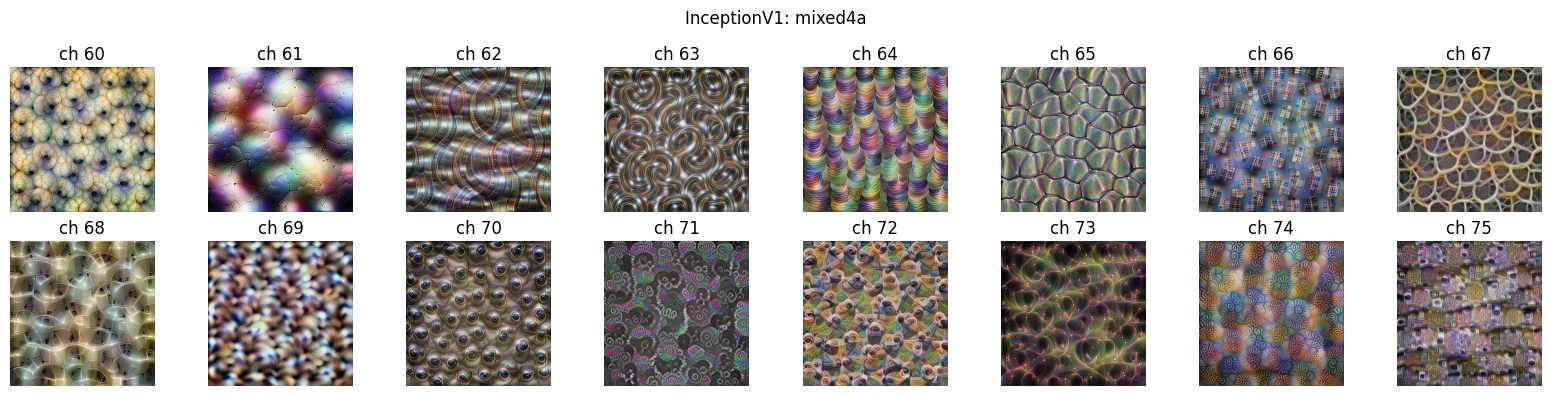

In [25]:
#!/usr/bin/env python3

import torch
import numpy as np
import matplotlib.pyplot as plt

# Lucent imports:
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

###############################################################################
# 1) Load InceptionV1
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True).to(device).eval()

###############################################################################
# 2) Define a simple param function
###############################################################################
def param_f():
    """
    Returns a pixel-space parameterization for a single 224x224 image
    that Lucent can optimize.
    """
    # param.image(width, height, fft=False) => direct pixel param
    # Or simply param.image(224,224)
    return param.image(224, 224, batch=1, device=device)

###############################################################################
# 3) Activation Maximization for a single channel
###############################################################################
def run_inception_max(layer_name, channel_idx, n_iter=256):
    """
    Runs activation maximization for InceptionV1 at (layer_name, channel_idx)
    for n_iter steps, returning a NumPy image (H,W,3).
    """
    # Define objective: maximize channel's activation
    objective_f = objectives.channel(layer_name, channel_idx)

    # Some typical transforms to help produce more interpretable images
    transforms_ = [
        transform.jitter(8),
        transform.pad(16),
        transform.random_scale([1.0, 1.2]),
        transform.random_rotate([-15, 15]),
    ]

    # thresholds=[n_iter] => a single "phase" of n_iter optimization steps
    vis = render.render_vis(
        model,
        objective_f,
        param_f=param_f,
        transforms=transforms_,
        thresholds=[n_iter],
        show_image=False,
        progress=False
    )

    # Lucent returns nested lists: vis[phase_index][image_index]
    result_img = vis[0][0]  # final image

    # If it's a PyTorch tensor, shape might be (B,C,H,W)
    if isinstance(result_img, torch.Tensor):
        if len(result_img.shape) == 4:
            # e.g. (1,3,224,224)
            result_img = result_img[0]  # => (3,224,224)
        # Convert to (224,224,3)
        result_img = result_img.detach().cpu().permute(1,2,0).numpy()
    else:
        # If it's a NumPy array shape (C,H,W), transpose
        if len(result_img.shape) == 3 and result_img.shape[0] in [1,3]:
            result_img = np.transpose(result_img, (1,2,0))

    return result_img

###############################################################################
# 4) Subplot function to visualize multiple channels
###############################################################################
def show_inception_layer_grid(layer_name, channel_indices, n_iter=256, n_cols=8):
    """
    For each channel in `channel_indices`, run activation max and display
    them side by side in a subplot grid.
    """
    images = []
    for ch in channel_indices:
        print(f"Maximizing channel {ch} in {layer_name}...")
        img = run_inception_max(layer_name, ch, n_iter=n_iter)
        images.append(img)

    n_channels = len(channel_indices)
    n_rows = int(np.ceil(n_channels / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    axes = axes.flatten() if n_rows>1 else axes

    for i, img in enumerate(images):
        ax = axes[i]
        # clamp to [0,1] so we don't get "Clipping input data" warnings
        ax.imshow(np.clip(img, 0, 1))
        ax.set_title(f"ch {channel_indices[i]}")
        ax.axis("off")

    # Hide leftover axes if any
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"InceptionV1: {layer_name}")
    plt.tight_layout()
    plt.show()

###############################################################################
# 5) Example usage
###############################################################################
if __name__ == "__main__":
    # For example, let's examine "mixed4a"
    # Olah's Distill articles often mention interesting channels in mixed4a
    layer_name = "mixed4a"

    # We'll look at channels 60..75. 
    # Some known arcs might appear around channel 65, etc.
    channel_list = range(60, 76)

    # Show them in a grid
    show_inception_layer_grid(layer_name, channel_list, n_iter=256, n_cols=8)